In [113]:
import pandas as pd
import shapely
from shapely import LineString, Point

import gtfs_archive
import pyproj


In [211]:
MPH_CONVERT = 2.23694

In [108]:
archive = gtfs_archive.get_gtfs_archive(20230615)
shapes = pd.read_csv(archive/"shapes.txt")
stops = pd.read_csv(archive/"stops.txt")
geod = pyproj.Geod(ellps="WGS84") # this is the model of the earth we use for distances.

Archive for 20230615 already exists: 20230614


# Below is a sample of how to find the distance for a single shape

In [60]:
# This is the first one in the shape file. It corresponds to bus route 1 northbound
shape010111 = shapes.loc[shapes.shape_id == "010111"].sort_values(by="shape_pt_sequence")
shape010111

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,010111,42.329848,-71.083876,10001,NaN
1,010111,42.329788,-71.083268,10002,NaN
2,010111,42.330089,-71.083198,10003,NaN
3,010111,42.330296,-71.083161,10004,NaN
4,010111,42.330493,-71.083112,10005,NaN
...,...,...,...,...,...
181,010111,42.372766,-71.116680,230006,NaN
182,010111,42.372888,-71.117129,230007,NaN
183,010111,42.372964,-71.117384,230008,NaN
184,010111,42.373096,-71.117908,230009,NaN


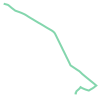

In [61]:
# note: shapely expects x,y coordinates so we have to give the points in lon, lat order.
linestring = shapely.LineString(shape010111[["shape_pt_lon","shape_pt_lat"]].to_numpy())
linestring

In [62]:
geod.geometry_length(linestring) # in meters -- This checks out with a map.

7165.159774335612

# Now let's try to calculate for all the shapes?

In [63]:
dists = {}
linestrings = {}
for name, group in shapes.groupby("shape_id"):
    pts = group[["shape_pt_lon", "shape_pt_lat"]].to_numpy()
    ls = shapely.LineString(pts)
    dists[name] = geod.geometry_length(ls)
    linestrings[name] = ls

In [7]:
distances = pd.Series(dists).rename(index="distance_m")
distances.to_csv("shape_distances.txt")

In [115]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]


In [178]:
def inner_piece(line, p1, p2):
    l2 = cut(line, line.project(p2))[0]
    l1 = cut(l2, line.project(p1))[-1]
    return l1

# Now we load all the trip/times data and group by route?

In [8]:
all_data = pd.read_csv("./data/in-data/2023/MBTA-Bus-Arrival-Departure-Times_2023-06.csv", parse_dates=["actual"])

In [9]:
# subset the data
data = all_data.loc[(all_data.route_id == "01") & (all_data.direction_id == "Outbound")]

In [10]:
def get_timepoints(data):
    all_timepoints = data[["time_point_id", "time_point_order"]].value_counts().to_frame("counts")
    filtered_timepoints = all_timepoints.loc[all_timepoints["counts"] > 100].groupby("time_point_id").idxmax()["counts"].tolist()
    timepoints = pd.DataFrame(filtered_timepoints, columns=["time_point_id", "time_point_order"]).sort_values(by="time_point_order").reset_index(drop=True)
    # chks = get_checkpoints()
    # timepoints["name"] = timepoints["time_point_id"].map(chks)
    return timepoints

In [146]:
def get_timepoints2(df):
    popular = df.groupby('half_trip_id')[['time_point_id', 'stop_id']].agg(['first','last']).value_counts().reset_index().iloc[0]
    return popular

In [277]:
data.groupby("half_trip_id")[['time_point_id','stop_id']].agg(['first', 'last']).value_counts()
#popular

(time_point_id, first)  (time_point_id, last)  (stop_id, first)  (stop_id, last)
rugg                    fldcr                  17863             323                993
                        kane                   17863             1508               912
                        peter                  17863             15100              514
nubn                    kane                   64000             1508                42
malcx                   fldcr                  1259              323                 21
rugg                    roxbs                  17863             11257                1
Name: count, dtype: int64

In [11]:
get_timepoints(data)

,time_point_id,time_point_order
0,nubn,1
1,Melwa,2
2,Wasma,3
3,masta,4
4,hynes,5
5,mit,6
6,cntsq,7
7,maput,8
8,hhgat,9


In [12]:
get_timepoints(data).iloc[[0,-1]].time_point_id

0     nubn
8    hhgat
Name: time_point_id, dtype: object

In [13]:
ends = get_timepoints(data).iloc[[0,-1]].time_point_id
trip_durations = data.loc[data.time_point_id.isin(ends)].groupby(["half_trip_id"]).agg({"actual": lambda x: x.max() - x.min()})
trip_durations = trip_durations.loc[trip_durations.actual > pd.Timedelta(0)]

In [14]:
geod.geometry_length(linestring) * len(trip_durations) / trip_durations.actual.sum().total_seconds()

3.356414981837176

In [16]:
all_rps = pd.read_csv("./data/gtfs_archives/20230607/route_patterns.txt")
all_rps = all_rps.loc[all_rps.route_pattern_typicality == 1]
def get_rep_trip_id(route_id, dir_id):
    route_id = route_id.lstrip("0")
    if dir_id == "Outbound":
        dir = 0
    elif dir_id == "Inbound":
        dir = 1
    else:
        print("invalid direction")
        return None
    sel = all_rps.loc[(all_rps.route_id == route_id) & (all_rps.direction_id == dir)]
    if len(sel) > 1:
        print(f"multiple route patterns found for {route_id}-{dir_id}")
        return None
    if len(sel) == 0:
        print(f"no route pattern found for {route_id}-{dir_id}")
        return None
    return sel.iloc[0].representative_trip_id

In [17]:
all_trips = pd.read_csv("./data/gtfs_archives/20230607/trips.txt")
def get_shape_id(rep_trip_id):
    trip = all_trips.loc[all_trips.trip_id == rep_trip_id]
    return trip.iloc[0].shape_id

In [257]:
import numpy as np
np.seterr(invalid='ignore')
def get_speed(subset):
    return subset.distance.sum() / subset.actual.sum().total_seconds() * MPH_CONVERT

In [354]:
pokey = []
for route_id in ['120']:#all_data.route_id.unique():
    perroute = []
    for direction_id in ["Outbound", "Inbound"]:
        rep_trip_id = get_rep_trip_id(route_id, direction_id)
        if not rep_trip_id:
            continue
        shape_id = get_shape_id(rep_trip_id)
        data = all_data.loc[(all_data.route_id == route_id) & (all_data.direction_id == direction_id)]
        popular = get_timepoints2(data)
        # print(popular)
        # ends = tpts.iloc[[0,-1]].time_point_id
        ends = [popular[('time_point_id', 'first')], popular[('time_point_id','last')]]
        trip_durations = data.loc[data.time_point_id.isin(ends)].groupby(["half_trip_id"]).agg(
            actual=pd.NamedAgg(column="actual", aggfunc=lambda x: x.max() - x.min()),
            start_time=pd.NamedAgg(column="actual", aggfunc="min"),
            end_time=pd.NamedAgg(column="actual", aggfunc="max"),
            service_date=pd.NamedAgg(column="service_date", aggfunc="first")
        )
        trip_durations = trip_durations.loc[trip_durations.actual > pd.Timedelta(0)]
        trip_durations['service_date'] = pd.to_datetime(trip_durations.service_date)
        ls = linestrings[shape_id]
        stop1 = stops.loc[stops.stop_id == str(popular[('stop_id','first')])]
        stop2 = stops.loc[stops.stop_id == str(popular[('stop_id','last')])]
        begin = shapely.Point(stop1.stop_lon, stop1.stop_lat)
        end = shapely.Point(stop2.stop_lon, stop2.stop_lat)
        segment = inner_piece(ls, begin, end)
        dist = geod.geometry_length(segment)
        # print(dist)
        trip_durations['distance'] = dist
        # trip_durations['peak'] = trip_durations.start_time.dt.hour.isin([6,7,8,15,16,17]) & trip_durations.service_date.dt.day_of_week < 5
        trip_durations['day'] = trip_durations.start_time.dt.hour.isin(range(7,19)) & (trip_durations.service_date.dt.day_of_week < 5)
        # speed = dist * len(trip_durations) / trip_durations.actual.sum().total_seconds()
        day_subset = trip_durations.loc[trip_durations.day]
        day_speed = get_speed(day_subset)
        day_count = len(day_subset)
        other_subset = trip_durations.loc[~trip_durations.day]
        other_speed = get_speed(other_subset)
        other_count = len(other_subset)
        total_speed = get_speed(trip_durations)
        total_count = len(trip_durations)
        # TODO: add total stops/mile
        res = [route_id, direction_id, day_speed, day_count, other_speed, other_count, total_speed, total_count, dist, ends[0], ends[1]]
        # print(res)
        perroute.append(res)
    pokey.extend(perroute)

        

In [355]:
data[['time_point_id','time_point_order']].value_counts()

time_point_id  time_point_order
cntle          3                   1032
mavj           4                   1032
orhgt          1                   1032
woodi          2                   1032
jefpt          5                   1011
mavck          6                   1011
Name: count, dtype: int64

In [206]:
# cool 1 inbound breakdown by hour of day. 7a-7p feels very justified for this route.
trip_durations.groupby(trip_durations.start_time.dt.hour).apply(lambda x: get_speed(x)))

start_time
0     12.104274
1     12.204356
2     13.106844
5     12.206272
6     10.687410
7      8.766635
8      8.022942
9      7.943735
10     8.210204
11     7.689508
12     7.243122
13     6.623275
14     6.624388
15     6.410991
16     6.310750
17     6.610642
18     7.253609
19     8.244988
20     8.373449
21     8.577696
22     9.413900
23    10.416301
dtype: float64

In [166]:
pd.DataFrame(pokey).sort_values(by=2).to_csv("pokey_prelim.csv")

In [282]:
p2 = pokey.copy()

In [308]:
fdf = pd.DataFrame(p2)
fdf.columns = ("route_id", "direction_id", "day_speed", "day_trip_count", "offhour_speed", "offhour_trip_count", "total_speed", "total_trip_count", "distance_m", "from_timepoint", "to_timepoint")
fdf['offhour_speed_minus_day_speed'] = fdf.offhour_speed - fdf.day_speed
fdf.sort_values(by='day_speed').head(20)
fdf.to_csv("pokey_data_breakdown.csv", index=False)

In [314]:
fdf

,route_id,direction_id,day_speed,day_trip_count,offhour_speed,offhour_trip_count,total_speed,total_trip_count,distance_m,from_timepoint,to_timepoint,offhour_speed_minus_day_speed
0,01,Outbound,6.652898,1143,8.324742,1316,7.454049,2459,7113.578755,nubn,hhgat,1.671844
1,01,Inbound,6.995369,1223,9.140172,1261,7.941371,2484,7403.192761,hhgat,nubn,2.144803
2,07,Outbound,10.436364,1026,12.966776,399,11.039575,1425,4699.186524,otsum,ctypt,2.530413
3,07,Inbound,9.202944,1026,11.358806,420,9.739881,1446,4718.285399,ctypt,otsum,2.155862
4,08,Outbound,7.969297,415,10.501997,419,9.067974,834,13626.351826,kenbs,umass,2.532700
...,...,...,...,...,...,...,...,...,...,...,...,...
244,96,Inbound,9.547452,406,11.692456,425,10.535970,831,7447.189503,medfd,bally,2.145004
245,97,Outbound,10.355388,308,10.395559,85,10.364050,393,7827.290511,welst,malst,0.040171
246,97,Inbound,10.568859,300,10.900851,110,10.655929,410,8096.536643,malst,welst,0.331992
247,99,Outbound,12.633822,279,13.874693,219,13.151045,498,11245.446202,welst,uphgh,1.240871


In [358]:
pivoted = fdf.pivot(columns="direction_id", index="route_id")
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
sum = pivoted.day_trip_count_Outbound + pivoted.day_trip_count_Inbound
# mean = (pivoted.day_speed_Inbound * pivoted.day_trip_count_Inbound + pivoted.day_speed_Outbound * pivoted.day_trip_count_Outbound) / sum
mean = (pivoted.day_speed_Inbound + pivoted.day_speed_Outbound) / 2
pivoted['trip_count'] = sum
pivoted['mean_speed_mph'] = mean
# pivoted.to_csv("pokey_data_breakdown_pivoted.csv")
top = pivoted[['trip_count','mean_speed_mph']].sort_values(by='mean_speed_mph')
# top.to_csv("pokey_day_top.csv")
top.head(15)


,trip_count,mean_speed_mph
route_id,,
55,366.0,6.137352
120,1090.0,6.782931
01,2366.0,6.824133
91,767.0,6.835080
85,6.0,7.074451
15,1109.0,7.103746
92,469.0,7.218922
66,2395.0,7.248246
23,2480.0,7.315070


In [345]:
fdf['diff'] = fdf.offhour_speed - fdf.day_speed

In [346]:
fdf.sort_values(by='diff', ascending=True).head(20)

,route_id,direction_id,day_speed,day_trip_count,offhour_speed,offhour_trip_count,total_speed,total_trip_count,distance_m,from_timepoint,to_timepoint,offhour_speed_minus_day_speed,diff
132,428,Inbound,13.918635,9,12.533443,20,12.932885,29,22312.032264,oakvl,hayms,-1.385191,-1.385191
62,202,Outbound,10.682423,231,10.123038,8,10.662701,239,4028.733258,fldcr,keyst,-0.559385,-0.559385
74,217,Outbound,13.692529,58,13.176918,18,13.566797,76,15087.134711,ashmt,qnctr,-0.515611,-0.515611
171,55,Outbound,6.234577,189,6.037085,63,6.184002,252,2939.565236,stjim,jqnsb,-0.197492,-0.197492
189,62,Outbound,17.813706,307,17.730752,175,17.783499,482,20150.528837,alewf,vahsp,-0.082954,-0.082954
245,97,Outbound,10.355388,308,10.395559,85,10.364050,393,7827.290511,welst,malst,0.040171,0.040171
128,424,Inbound,13.972636,37,14.225612,43,14.107482,80,13299.590587,essex,wondw,0.252976,0.252976
44,131,Inbound,13.238728,148,13.531171,15,13.265110,163,11327.694073,mrose,malst,0.292443,0.292443
246,97,Inbound,10.568859,300,10.900851,110,10.655929,410,8096.536643,malst,welst,0.331992,0.331992
61,201,Inbound,10.876699,418,11.258284,507,11.082585,925,3299.613444,adgal,fldcr,0.381584,0.381584


In [278]:
fdf.day_speed * fdf.day_trip_count

0       7604.262160
1       8555.336317
2      10707.708987
3       9442.220844
4       3307.258193
           ...     
244     3876.265462
245     3189.459515
246     3170.657794
247     3524.836308
248     4035.331438
Length: 249, dtype: float64

In [156]:
get_shape_id(get_rep_trip_id("171", "Outbound"))

'1710019'

In [157]:
data = all_data.loc[(all_data.route_id == "171") & (all_data.direction_id == "Outbound")]

In [34]:
pokey = []

def analyze(route_id, dir):
    print(route_id)
    for direction_id in [["Outbound", "Inbound"][dir]]:
        print(direction_id)
        rep_trip_id = get_rep_trip_id(route_id, direction_id)
        if not rep_trip_id:
            continue
        shape_id = get_shape_id(rep_trip_id)
        data = all_data.loc[(all_data.route_id == route_id) & (all_data.direction_id == direction_id)]
        tpts = get_timepoints(data)
        if tpts.empty:
            continue
        ends = tpts.iloc[[0,-1]].time_point_id
        trip_durations = data.loc[data.time_point_id.isin(ends)].groupby(["half_trip_id"]).agg({"actual": lambda x: x.max() - x.min()})
        trip_durations = trip_durations.loc[trip_durations.actual > pd.Timedelta(0)]
        speed = distances[shape_id] * len(trip_durations) / trip_durations.actual.sum().total_seconds()
        count = trip_durations.actual.count()
        print(route_id, direction_id, speed, count)
        pokey.append([route_id, direction_id, speed, count])
        

In [47]:
analyze('34',1)

34
Inbound
34 Inbound 8.383787660223717 237


In [50]:
get_rep_trip_id('34', "Inbound")

'55889533'

In [40]:
trip_durations

,actual
half_trip_id,
59644942.0,0 days 00:44:40
59644946.0,0 days 00:37:51
59644948.0,0 days 00:33:12
59644950.0,0 days 00:29:07
59644952.0,0 days 00:18:38
...,...
59957684.0,0 days 00:39:57
59957686.0,0 days 00:31:33
59957688.0,0 days 00:36:05
